In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
torch.manual_seed(5252)
np.random.seed(5252)

--------------------------------------------------------------------------------------------------------------------------------
###                                      Generation of Data      -         Synthetic Data - 1
--------------------------------------------------------------------------------------------------------------------------------

In [3]:
# parameters of the (latent) gaussians
mus = (np.array([-2., -2.]), np.array([2., 2.]))
covs = (
    np.array([[0.5, 0.],[0., 0.5]]),
    np.array([[0.3, 0.1], [0.1, 0.3]]),
)

In [4]:
n_features = 2
n_classes = len(mus)
n_samples_per_class = 10000

features = []
labels = []

for i in range(n_classes):
    features.append(
        np.random.multivariate_normal(mean=mus[i], 
                                      cov=covs[i],
                                      size=(n_samples_per_class,))
    )
    labels.append([i]*n_samples_per_class)

In [5]:
features_orig = np.array(features).reshape(n_classes*n_samples_per_class, n_features)
labels_orig = np.array(labels).reshape(n_classes*n_samples_per_class, 1).squeeze()

--------------------------------------------------------------------------------------------------------------------------------
###                                      Generation of Data      -         Synthetic Data - 2
--------------------------------------------------------------------------------------------------------------------------------

In [3]:
# parameters of the (latent) gaussians
mus = (np.array([-5., -3.]), np.array([5., 3.]))
covs = (
    np.array([[0.1, 0.],[0., 0.8]]),
    np.array([[0.3, 0.3], [0.9, 0.1]]),
)

In [4]:
n_features = 2
n_classes = len(mus)
n_samples_per_class = 10000

features = []
labels = []

for i in range(n_classes):
    features.append(
        np.random.multivariate_normal(mean=mus[i], 
                                      cov=covs[i],
                                      size=(n_samples_per_class,))
    )
    labels.append([i]*n_samples_per_class)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_8312\3180878226.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  np.random.multivariate_normal(mean=mus[i],


In [5]:
features_orig = np.array(features).reshape(n_classes*n_samples_per_class, n_features)
labels_orig = np.array(labels).reshape(n_classes*n_samples_per_class, 1).squeeze()

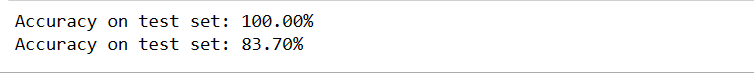

## View latent dataset

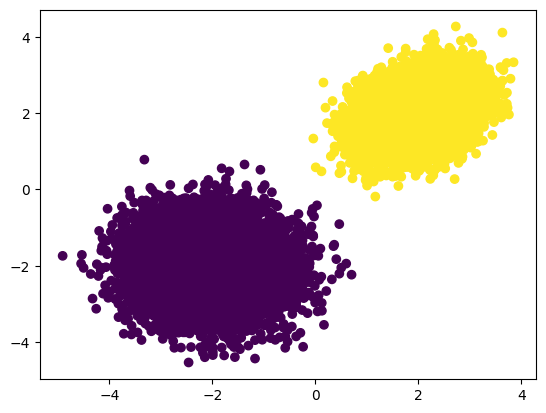

In [6]:
plt.scatter(
    features_orig[:,0], features_orig[:,1], c=labels_orig
)

In [7]:
labels_orig.shape

(20000,)

In [8]:
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    out1 = x*y
    out2 = x + np.exp(-y/10.)
    out3 = (np.log(x*x*y*y) + 10*x*x*y - x)/100.
    return np.stack((out1, out2, out3), axis=-1)

In [9]:
def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = np.log(x*x*y*y) + 10*x*y*np.sin(x)
    out2 = y - 10*x*y
    out3 = x*y*np.tan(y)
    return np.stack((out1, out2, out3), axis=-1)

In [10]:
warped_features_1 = warp1(features_orig)
warped_features_2 = warp2(features_orig)

### Function 2

In [6]:
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    out1 = x**y
    out2 = np.exp(x) + np.exp(-y/10.)
    out3 = (np.log(x**y) - 10*x*x*y - x**y)/100.
    return np.stack((out1, out2, out3), axis=-1)

In [7]:
def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = np.log(x*x*y*y) + 10*x*np.cos(y)*np.sin(x)
    out2 = np.exp(y) - 10*x*y
    out3 = np.cos(x)*y*np.tan(y)
    return np.stack((out1, out2, out3), axis=-1)

In [8]:
warped_features_1 = warp1(features_orig)
warped_features_2 = warp2(features_orig)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_8312\171495252.py:4: RuntimeWarning: invalid value encountered in power
  out1 = x**y
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_8312\171495252.py:6: RuntimeWarning: invalid value encountered in power
  out3 = (np.log(x**y) - 10*x*x*y - x**y)/100.


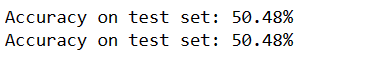

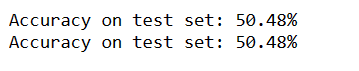 with the second dataset that performed very well with the first functions

## Data Generated by Lorenzo

In [3]:
n_features = 2
n_classes = 2
n_samples_per_class = 1000

In [4]:
from sklearn.datasets import make_classification
features_orig_1, labels_orig_1 = make_classification(
    n_samples=n_samples_per_class*n_classes//2,
    n_informative=n_features,
    n_features=4,
    flip_y=0.,
    shuffle=False,
    shift=-0.3,
    random_state=5252
)

In [5]:
features_orig_2, labels_orig_2 = make_classification(
    n_samples=n_samples_per_class*n_classes//2,
    n_informative=n_features,
    n_features=4,
    flip_y=0.,
    shuffle=False,
    shift=+0.3,
    random_state=5252
)

In [6]:
features_orig = np.concatenate((features_orig_1, features_orig_2))
labels_orig = np.concatenate((labels_orig_1, labels_orig_2))

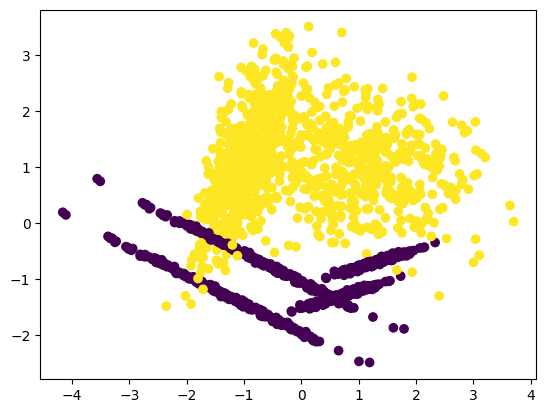

In [7]:
plt.scatter(
    features_orig[:,0], features_orig[:,1], c=labels_orig
)

## Warp Data

In [8]:
use_simple_warp_functions = True

In [9]:
# Difficult warp functions
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    out1 = x*y
    out2 = x + np.exp(-y/10.)
    out3 = (np.log(x*x*y*y) + 10*x*x*y - x)/100.
    return np.stack((out1, out2, out3), axis=-1)

def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = np.log(x*x*y*y) + 10*x*y*np.sin(x)
    out2 = y - 10*x*y
    out3 = x*y*np.tan(y)
    return np.stack((out1, out2, out3), axis=-1)

In [8]:
# Other warping 1
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    
    t = 1.5 * np.pi * (1 + 2 * x/x.max())
    out1 = t * np.cos(t)
    out2 = t * np.sin(t)
    out3 = 21 * np.power(y/y.max(), 2)
    
    return np.stack((out1/out1.max(), out2/out2.max(), out3/out3.max()), axis=-1)

def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = y - 5*x*y
    out2 = 10*y*y + a[:,3]
    return np.stack((out1/out1.max(), out2/out2.max(), a[:,2]), axis=-1)

In [9]:
# Other warping 2
def warp1(a):
    x = a[:,0]
    y = a[:,1]
    
    out1 = x
    out2 = y
    out3 = x+y
    
    return np.stack((out1, out2, out3), axis=-1)

def warp2(a):
    x = a[:,0]
    y = a[:,1]
    out1 = 1e+4*x
    out2 = 1e+4*y
    out3 = 1e+4*(x - y)
    #out4 = 1e+4*(x + y)
    #return np.stack((out1, out2, out3, out4), axis=-1)
    return np.stack((out1, out2, out3), axis=-1)

In [9]:
# Simpler warp functions
if use_simple_warp_functions:
    def warp1(a):
        x = a[:,0]
        y = a[:,1]
        out1 = x + y
        out2 = 10*x
        out3 = y - x
        return np.stack((out1, out2, out3), axis=-1)

    def warp2(a):
        x = a[:,0]
        y = a[:,1]
        out1 = y - 5*x
        out2 = 10*y
        out3 = y + x*x
        return np.stack((out1, out2, out3), axis=-1)

In [10]:
warped_features_1 = warp1(features_orig)
warped_features_2 = warp2(features_orig)

## View dataset for client 1

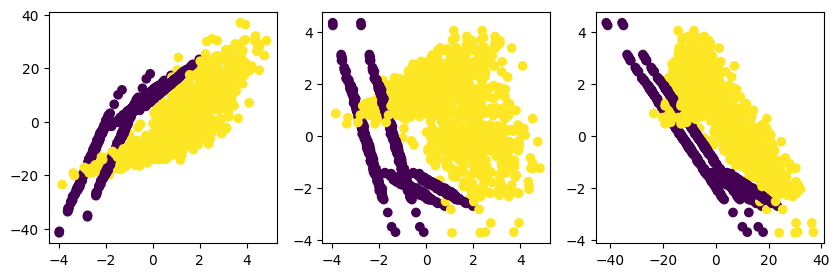

In [11]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].scatter(
    warped_features_1[:,0], warped_features_1[:,1], c=labels_orig
)
ax[1].scatter(
    warped_features_1[:,0], warped_features_1[:,2], c=labels_orig
)
ax[2].scatter(
    warped_features_1[:,1], warped_features_1[:,2], c=labels_orig
)

## View dataset for client 2

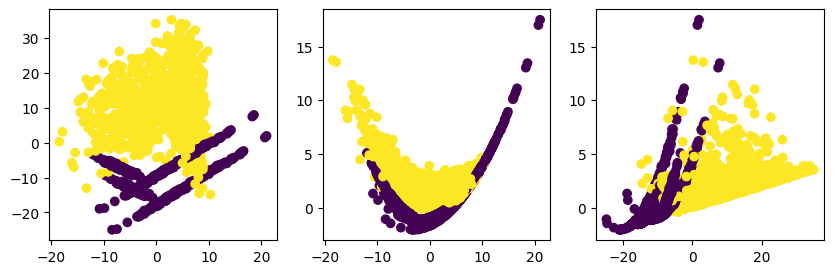

In [12]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].scatter(
    warped_features_2[:,0], warped_features_2[:,1], c=labels_orig
)
ax[1].scatter(
    warped_features_2[:,0], warped_features_2[:,2], c=labels_orig
)
ax[2].scatter(
    warped_features_2[:,1], warped_features_2[:,2], c=labels_orig
)

### Preparing the data

In [13]:
X_train_C1, X_test_C1, y_train_C1, y_test_C1 = train_test_split(torch.tensor(warped_features_1), torch.tensor(labels_orig), test_size=0.2, random_state=42)
X_train_C2, X_test_C2, y_train_C2, y_test_C2 = train_test_split(torch.tensor(warped_features_2), torch.tensor(labels_orig), test_size=0.2, random_state=42)

In [14]:
X_train_all_C1 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_train_C1)), torch.tensor(np.hstack(y_train_C1)))
X_test_all_C1 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_test_C1)), torch.tensor(np.hstack(y_test_C1)))

In [15]:
X_train_all_C2 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_train_C2)), torch.tensor(np.hstack(y_train_C2)))
X_test_all_C2 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_test_C2)), torch.tensor(np.hstack(y_test_C2)))

In [16]:
trainloader_C1= torch.utils.data.DataLoader(X_train_all_C1, batch_size=64, shuffle=True, num_workers=2)
testloader_C1 = torch.utils.data.DataLoader(X_test_all_C1, batch_size=64, shuffle=False, num_workers=2)

In [17]:
trainloader_C2 = torch.utils.data.DataLoader(X_train_all_C2, batch_size=64, shuffle=True, num_workers=2)
testloader_C2 = torch.utils.data.DataLoader(X_test_all_C2, batch_size=64, shuffle=False, num_workers=2)

### ---------------------------------------------------------Federated Avaraging------------------------------------------------------------------------

In [18]:
class Client1_Fed(nn.Module):
    def __init__(self):
        super(Client1_Fed, self).__init__()
         
        self.num_samples = 10
        
        
        

        self.encoder_model = nn.Sequential(nn.Linear(3, 20, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(20, 10, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(10, 8, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(8, 5, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(5, 3, dtype=torch.float64),
                                           nn.Softmax(dim=1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, inputs):
        outputs_encoder = self.encoder_model(inputs)
        latent_parameters = list(self.encoder_model.parameters())
        return outputs_encoder, latent_parameters


    def update(self, latent_parameters):
        # Get the parameters of the latent model
        latent_params = self.encoder_model.parameters()
    
        # Iterate over the parameters and update them with new values
        for param, new_value in zip(latent_params, latent_parameters):
            param.data.copy_(new_value)
    
    def train_step(self, inputs, labels):
        
        #Forward pass
        logits, latent_parameters = self.forward(inputs)

        #Compute the loss
        labels = labels.long()
        loss = self.loss_function(logits, labels)

        #Zero the gradients
        self.optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #updare the parameters
        self.optimizer.step()

        return loss.item(), latent_parameters

In [19]:
class Client2_Fed(nn.Module):
    def __init__(self):
        super(Client2_Fed, self).__init__()

        
        
        
        

        self.encoder_model = nn.Sequential(nn.Linear(3, 20, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(20, 10, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(10, 8, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(8, 5, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(5, 3, dtype=torch.float64),
                                           nn.Softmax(dim=1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, inputs):
        outputs_encoder = self.encoder_model(inputs)
        latent_parameters = list(self.encoder_model.parameters())
        return outputs_encoder, latent_parameters


    def update(self, latent_parameters):
        # Get the parameters of the latent model
        latent_params = self.encoder_model.parameters()
    
        # Iterate over the parameters and update them with new values
        for param, new_value in zip(latent_params, latent_parameters):
            param.data.copy_(new_value)
    
    def train_step(self, inputs, labels):
        
        #Forward pass
        logits, latent_parameters = self.forward(inputs)

        #Compute the loss
        labels = labels.long()
        loss = self.loss_function(logits, labels)

        #Zero the gradients
        self.optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #updare the parameters
        self.optimizer.step()

        return loss.item(), latent_parameters

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_9948\391768613.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_c1 = torch.tensor(x_c1)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_9948\391768613.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_c1 = torch.tensor(y_c1, dtype=torch.long)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_9948\391768613.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_c2 = torch.tensor(x_c2)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_9948\391768613.py:22: UserWarning: To copy construct fro

Epoch [1/25], Loss: 1.0542
Epoch [1/25], Loss: 1.0416
Epoch [2/25], Loss: 1.0426
Epoch [2/25], Loss: 0.9134
2
Epoch [3/25], Loss: 1.0369
Epoch [3/25], Loss: 1.0490
Epoch [4/25], Loss: 0.9983
Epoch [4/25], Loss: 1.0152
4
Epoch [5/25], Loss: 0.9775
Epoch [5/25], Loss: 0.9606
Epoch [6/25], Loss: 0.9728
Epoch [6/25], Loss: 0.8453
6
Epoch [7/25], Loss: 0.9633
Epoch [7/25], Loss: 0.7830
Epoch [8/25], Loss: 0.9386
Epoch [8/25], Loss: 0.6529
8
Epoch [9/25], Loss: 0.9381
Epoch [9/25], Loss: 0.6576
Epoch [10/25], Loss: 0.8685
Epoch [10/25], Loss: 0.6356
10
Epoch [11/25], Loss: 0.8589
Epoch [11/25], Loss: 0.6331
Epoch [12/25], Loss: 0.7434
Epoch [12/25], Loss: 0.6167
12
Epoch [13/25], Loss: 0.7680
Epoch [13/25], Loss: 0.5871
Epoch [14/25], Loss: 0.6583
Epoch [14/25], Loss: 0.6498
14
Epoch [15/25], Loss: 0.6752
Epoch [15/25], Loss: 0.6710
Epoch [16/25], Loss: 0.6739
Epoch [16/25], Loss: 0.6355
16
Epoch [17/25], Loss: 0.7573
Epoch [17/25], Loss: 0.5692
Epoch [18/25], Loss: 0.6325
Epoch [18/25], Los

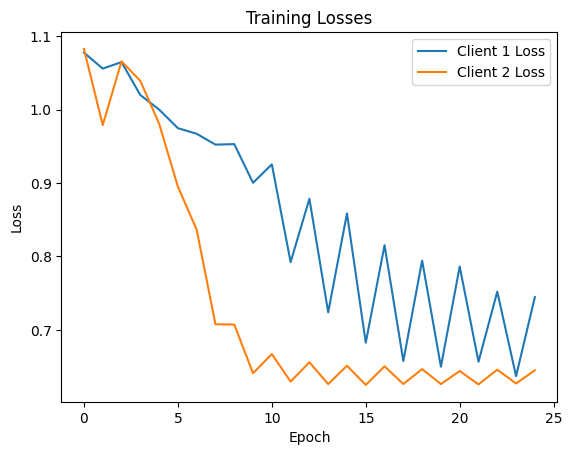

In [20]:
client1_Fed = Client1_Fed()
client2_Fed = Client2_Fed()


num_epochs = 25
latent_parameters = []
losses_1 = []
losses_2 = []

#training loop
for epoch in range(num_epochs):
    
    client1_Fed.train()
    client2_Fed.train()
    epoch_loss_1 = 0.0
    epoch_loss_2 = 0.0
    
    for  i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(trainloader_C1, trainloader_C2)): 
        x_c1 = torch.tensor(x_c1)
        y_c1 = torch.tensor(y_c1, dtype=torch.long)
        x_c2 = torch.tensor(x_c2)
        y_c2 = torch.tensor(y_c2, dtype=torch.long)
        loss_1, latent_parameters_1 = client1_Fed.train_step(x_c1, y_c1)
        loss_2, latent_parameters_2 = client2_Fed.train_step(x_c2, y_c2)
        
        epoch_loss_1 += loss_1  # Accumulate losses
        epoch_loss_2 += loss_2
        
    epoch_loss_1 /= len(trainloader_C1)  # Average losses
    epoch_loss_2 /= len(trainloader_C2)
    
    losses_1.append(epoch_loss_1)  # Append to the list of losses
    losses_2.append(epoch_loss_2)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_1:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_2:.4f}")
    if ((epoch+1) % 2 == 0):
        print(epoch+1)
        latent_parameters =[(x + y) / 2 for x, y in zip(latent_parameters_1, latent_parameters_2)]
        client1_Fed.update(latent_parameters)
        client2_Fed.update(latent_parameters)
    
    latent_parameters = []

# Plotting the losses
plt.plot(losses_1, label='Client 1 Loss')
plt.plot(losses_2, label='Client 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [21]:
total_accuracy_1 = 0.0
total_samples_1 = 0
total_accuracy_2 = 0.0
total_samples_2 = 0

for i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(testloader_C1, testloader_C2)):
    logits_1, _ = client1_Fed.forward(x_c1)
    logits_2, _ = client2_Fed.forward(x_c2)
        

    _, predictions_1 = torch.max(logits_1, 1)
    _, predictions_2 = torch.max(logits_2, 1)
        
    acc_1 = torch.mean((predictions_1 == y_c1).float())
    acc_2 = torch.mean((predictions_2 == y_c2).float())
    
    total_accuracy_1 += acc_1.item() * x_c1.size(0)
    total_samples_1 += x_c1.size(0)
    total_accuracy_2 += acc_2.item() * x_c2.size(0)
    total_samples_2 += x_c2.size(0)

final_accuracy_1 = total_accuracy_1 / total_samples_1
final_accuracy_2 = total_accuracy_2 / total_samples_2
print(f"Accuracy on test set: {final_accuracy_1 * 100:.2f}%")
print(f"Accuracy on test set: {final_accuracy_2 * 100:.2f}%")

Accuracy on test set: 87.25%
Accuracy on test set: 95.00%
